In [2]:
import cv2
import numpy as np
import glob
import mahotas as mt
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_roc_curve
import os


In [3]:
def segmented_part(image):
    img1 = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    s = img1[:, :, 1]
    bw_img1 = cv2.threshold(
        s, 70, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result1 = cv2.bitwise_and(image, image, mask=bw_img1)
    img2 = cv2.cvtColor(result1, cv2.COLOR_BGR2LAB)
    a = img2[:, :, 1]
    bw_img2 = cv2.threshold(
        a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result2 = cv2.bitwise_and(result1, result1, mask=bw_img2)
    return result2


def mean(image):
    img_arr = image.reshape(-1)
    img_arr = np.array(img_arr)
    m = img_arr[img_arr != 0].mean()
    return m/255


def std_deviation(image):
    img_arr = image.reshape(-1)
    img_arr = np.array(img_arr)
    s = img_arr[img_arr != 0].std()
    return s/255

In [5]:
train_imgs = []
train_labels = []
features = []
for directory_path in glob.glob("images/train/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = segmented_part(img)
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binary = cv2.threshold(
            gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
        l, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]

        contours, hierarchy = cv2.findContours(
            binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        M = cv2.moments(cnt)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)

        textures = mt.features.haralick(gray)
        ht_mean = textures.mean(axis=0)
        contrast = ht_mean[1]
        correlation = ht_mean[2]
        homogeneity = ht_mean[4]
        entropy = ht_mean[8]

        ftr = np.hstack([mean(r), mean(b), mean(g), mean(h), mean(s), mean(v), mean(l), mean(a), mean(b), std_deviation(
            r), std_deviation(b), std_deviation(g), area, perimeter, contrast, correlation, homogeneity, entropy])
        train_imgs.append(img)
        train_labels.append(label)
        features.append(ftr)

train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)
features = np.array(features)
print(features)

[[0.3139558  0.51485021 0.60354186 ... 0.89479802 0.91971706 1.34983344]
 [0.24676679 0.50425355 0.62231957 ... 0.47647715 0.98276047 0.26301826]
 [0.26491093 0.50485768 0.53972831 ... 0.57305446 0.97367623 0.41139268]
 ...
 [0.17526946 0.50616407 0.41275902 ... 0.43268246 0.95424314 0.67174725]
 [0.21696078 0.50323774 0.4460049  ... 0.22542012 0.9830768  0.24912316]
 [0.28683088 0.5077675  0.50884784 ... 0.50386669 0.93455409 0.95672562]]


In [6]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(train_labels_encoded)

[0 0 0 ... 3 3 3]


In [8]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(features)
print(rescaled_features)

[[0.60876361 0.2437285  0.7711199  ... 0.99187016 0.74174482 0.27653016]
 [0.46335199 0.04121075 0.80663999 ... 0.46756557 0.94820429 0.05006615]
 [0.50261985 0.05275653 0.65040957 ... 0.58861123 0.91845452 0.08098352]
 ...
 [0.30861624 0.0777236  0.41023322 ... 0.41267526 0.85481351 0.13523464]
 [0.39884532 0.02179701 0.47312146 ... 0.15290195 0.94924024 0.04717077]
 [0.55005937 0.10836749 0.59199576 ... 0.50189439 0.7903343  0.19461671]]


In [11]:
(x_train, x_test, y_train, y_test) = train_test_split(
    rescaled_features, train_labels_encoded, test_size=0.3, random_state=42)

In [13]:
svm = SVC(kernel='linear', probability=True, random_state=42)

In [14]:
svm.fit(x_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [15]:
svm_pred = svm.predict(x_test)

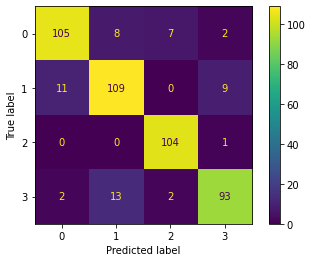

Accuracy:0.8819742489270386
Precision: 0.881516


In [30]:
accuracy = accuracy_score(y_test, svm_pred)
plot_confusion_matrix(svm, x_test, y_test)
plt.show()
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, svm_pred, average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_test, svm_pred, average='weighted')


In [20]:
support_vectors = svm.support_vectors_

plt.scatter(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3], x_train[:,4], x_train[:,5], x_train[:,6], x_train[:,7])
plt.scatter(support_vectors[:,0], support_vectors[:,1],support_vectors[:,2],support_vectors[:,3],support_vectors[:,4],support_vectors[:,5],support_vectors[:,6],support_vectors[:,7], color='red')
plt.title('Linearly separable data with support vectors')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

ValueError: Unrecognized marker style array([0.258982  , 0.37915729, 0.68915821, ..., 0.15963087, 0.40121152,
       0.2157105 ])

In [19]:
print(x_train)

[[0.50040275 0.16627479 0.49262896 ... 0.63051492 0.68452199 0.29756121]
 [0.59388328 0.19572477 0.75406072 ... 0.79791237 0.7556697  0.24465136]
 [0.08522133 0.00365952 0.16726485 ... 0.67646273 0.99337087 0.0072063 ]
 ...
 [0.73066214 0.05627882 0.80500493 ... 0.82536946 0.92464501 0.08164522]
 [0.47173199 0.18170881 0.64294906 ... 0.56972058 0.73207304 0.24961333]
 [0.4747103  0.0271582  0.44799962 ... 0.95540016 0.9550874  0.05000405]]
